# Analyze the target prob-weighted beta value matrix

## Package importing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os
import re

# Create PCA plots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

# Filter features
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegressionCV

# Heatmap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

import colorsys
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay

## Data loading

In [2]:
# Create nested dictionary structure for easier access
feature_type = 'dmrs'
# feature_type = 'cpgs'

summary_dir = '../results/summary'

dfs = {
    'train': {
        'assembled': pd.read_csv(f'{summary_dir}/train_assembled/prob_weighted_{feature_type}.tsv', sep='\t').dropna(axis=1).drop(columns=['label']),
        'unassembled': pd.read_csv(f'{summary_dir}/train_unassembled/prob_weighted_{feature_type}.tsv', sep='\t').dropna(axis=1).drop(columns=['label'])
    },
    'val': {
        'assembled': pd.read_csv(f'{summary_dir}/val_assembled/prob_weighted_{feature_type}.tsv', sep='\t').dropna(axis=1).drop(columns=['label']),
        'unassembled': pd.read_csv(f'{summary_dir}/val_unassembled/prob_weighted_{feature_type}.tsv', sep='\t').dropna(axis=1).drop(columns=['label'])
    }
}

# Filter for common columns between train and val for each assembly type
for assembly in ['assembled', 'unassembled']:
    common_cols = set(dfs['train'][assembly].columns) & set(dfs['val'][assembly].columns)
    dfs['train'][assembly] = dfs['train'][assembly][list(common_cols)]
    dfs['val'][assembly] = dfs['val'][assembly][list(common_cols)]

# Load and combine metadata
train_metadata = pd.read_csv('summary/train_meta.csv')
val_metadata = pd.read_csv('summary/val_meta.csv')
train_metadata['state'] = 'Arrest'
meta = pd.concat([train_metadata, val_metadata], axis=0)

# Merge metadata with each dataset
for split in ['train', 'val']:
    for assembly in ['assembled', 'unassembled']:
        df = dfs[split][assembly].copy()
        df = pd.merge(df, meta.drop_duplicates(), on='sample', how='inner')
        dfs[split][assembly] = df

early_df = pd.read_csv('summary/early_samples.tsv', sep='\t')
early_samples = early_df['sample'].tolist()
early_samples_features = [col for col in early_df.columns if ':' in col]

## Early sample PCA projection

In [3]:
def pca_feature_selection(df, labels_to_keep = ['T16', 'Normal']):
    # -----------------------------
    # Data Loading and Pre-Filtering
    # -----------------------------
    
    # Extract features and labels
    labels = df['label']
    feature_cols = [col for col in df.columns if ':' in col]  # Select CpG site columns
    X = df[feature_cols]
    X = X.dropna(axis=1)  # Remove features with missing values
    
    features = []
    
    # **1. Remove low-variance features**
    var_thresh = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
    X_filtered = pd.DataFrame(
        var_thresh.fit_transform(X),
        columns=X.columns[var_thresh.get_support()],
        index=X.index
    )
    print(f"Step 1: Low-variance filtering: {X.shape[1]} to {X_filtered.shape[1]} features retained.")
    
    # **2. Remove highly correlated features (unsupervised)**
    corr_matrix = X_filtered.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    X_final = X_filtered.drop(columns=to_drop)
    print(f"Step 2: Remove highly correlated features: {X_filtered.shape[1]} to {X_final.shape[1]} features retained.")
    
    # -----------------------------
    # 3. PCA-based Feature Selection
    # -----------------------------
    # Perform PCA and keep only the first two principal components
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_final)
    
    # PCA components (loadings): shape (2, n_features)
    # We take the absolute values of the loadings since the sign is arbitrary.
    loadings = np.abs(pca.components_)
    
    # Compute a combined score for each feature using the Euclidean norm of its loadings on PC1 and PC2.
    combined_scores = np.sqrt(loadings[0]**2 + loadings[1]**2)
    
    # Create a Series with feature names and their combined score.
    score_series = pd.Series(combined_scores, index=X_final.columns)
    score_series_sorted = score_series.sort_values(ascending=False)

    feature_sorted = score_series_sorted.index

    return feature_sorted

def lasso_feature_selection(df, labels_to_keep = ['T16', 'Normal']):
    # -----------------------------
    # Data Loading and Pre-Filtering
    # -----------------------------
    
    # Extract features and labels
    labels = df['label']
    feature_cols = [col for col in df.columns if ':' in col]  # Select CpG site columns
    X = df[feature_cols]
    X = X.dropna(axis=1)  # Remove features with missing values
    
    # Filter for specified labels
    mask = labels.isin(labels_to_keep)
    X = X[mask]
    y = labels[mask]

    y = y.map({labels_to_keep[0]: 1, labels_to_keep[1]: 0})
    
    # **1. Remove low-variance features**
    var_thresh = VarianceThreshold(threshold=0.01)
    X_filtered = pd.DataFrame(
        var_thresh.fit_transform(X),
        columns=X.columns[var_thresh.get_support()],
        index=X.index
    )
    print(f"Step 1: Low-variance filtering: {X.shape[1]} to {X_filtered.shape[1]} features retained.")
    
    # **2. Remove highly correlated features**
    corr_matrix = X_filtered.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    X_final = X_filtered.drop(columns=to_drop)
    print(f"Step 2: Remove highly correlated features: {X_filtered.shape[1]} to {X_final.shape[1]} features retained.")
    
    # -----------------------------
    # 3. Lasso-based Feature Selection
    # -----------------------------
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    
    # Fit Lasso with cross-validation to find optimal alpha
    lasso_cv = LassoCV(cv=5, random_state=42)
    lasso_cv.fit(X_scaled, y)
    
    # Get feature importance scores
    feature_importance = np.abs(lasso_cv.coef_)
    
    # Create a Series with feature names and their importance scores
    score_series = pd.Series(feature_importance, index=X_final.columns)
    score_series_sorted = score_series.sort_values(ascending=False)
    
    print(f"Step 3: Lasso selected {(feature_importance != 0).sum()} non-zero features")
    
    feature_sorted = score_series_sorted.index
    
    return feature_sorted

def single_pca_plot(df, feature_cols, labels_to_keep, title, new_df=None, plot_decision_boundary=True):
    # Helper function: Adjust base color using a gradient based on week.
    def get_gradient_color(base_color, week, min_week, max_week):
        norm = (week - min_week) / (max_week - min_week) if max_week != min_week else 0.5
        h, s, v = colorsys.rgb_to_hsv(*base_color)
        new_s = 0.1 + 0.9 * norm
        new_color = colorsys.hsv_to_rgb(h, new_s, v)
        return new_color

    # Compute global week range.
    if new_df is not None:
        combined_week = pd.concat([df['week'], new_df['week']])
        min_week, max_week = combined_week.min(), combined_week.max()
    else:
        min_week, max_week = df['week'].min(), df['week'].max()

    # Extract and standardize features.
    X = df[feature_cols]
    X_final = X.dropna(axis=1)
    kept_cols = X_final.columns
    title = f'{title} (n={X_final.shape[1]})'
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Get original labels, samples, weeks.
    labels = df['label']
    samples = df['sample']
    weeks = df['week']

    # Create a color mapping.
    palette = sns.color_palette("Set1", n_colors=len(labels_to_keep))
    label_colors = dict(zip(labels_to_keep, palette))
    sil_score = silhouette_score(X_pca, labels)
    orig_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                   for label, week in zip(labels, weeks)]
    
    # Fit logistic regression on PCA data.
    clf = LogisticRegression(random_state=42)
    clf.fit(X_pca, labels)
    
    # Process new data if available.
    if new_df is not None:
        new_X = new_df[feature_cols][kept_cols]
        new_X_scaled = scaler.transform(new_X)
        new_X_pca = pca.transform(new_X_scaled)
        new_labels = new_df['label']
        new_samples = new_df['sample']
        new_weeks = new_df['week']
        new_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                      for label, week in zip(new_labels, new_weeks)]
        
        # Compute confusion matrix for new data with proper label ordering.
        new_preds = clf.predict(new_X_pca)
        cm_new = confusion_matrix(new_labels, new_preds, labels=labels_to_keep)
    else:
        new_X_pca = None

    # Create one figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    
    # Plot PCA scatter (original data).
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=orig_colors, label='Original Data')
    
    # Plot the linear decision boundary if requested
    if plot_decision_boundary:
        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        x_vals = np.linspace(x_min, x_max, 100)
        if clf.coef_[0][1] != 0:
            y_vals = -(clf.coef_[0][0] * x_vals + clf.intercept_[0]) / clf.coef_[0][1]
            ax.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
        else:
            x_line = -clf.intercept_[0] / clf.coef_[0][0]
            ax.axvline(x=x_line, color='k', linestyle='--', label='Decision Boundary')
    
    # Overlay new data if provided.
    if new_df is not None:
        ax.scatter(new_X_pca[:, 0], new_X_pca[:, 1], marker='x', c=new_colors, s=100, label='New Data')
        for i, sample in enumerate(new_samples):
            ax.annotate(sample, (new_X_pca[i, 0], new_X_pca[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    
    # Annotate original data points.
    for i, sample in enumerate(samples):
        ax.annotate(sample, (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    ax.set_title(f'{title}\nSilhouette Score: {sil_score:.3f}')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    
    # Build legend.
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for label, color in label_colors.items()]
    if plot_decision_boundary:
        legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='k', label='Decision Boundary'))
    if new_df is not None:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', label='New Data', markersize=10))
    ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Right subplot: plot confusion matrix for new data.
    ax2 = axes[1]
    if new_df is not None:
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=labels_to_keep)
        cm_disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title('Confusion Matrix (New Data)')
    else:
        ax2.text(0.5, 0.5, "No new data provided for confusion matrix", ha="center", va="center")
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def single_pca_svm_plot(df, feature_cols, labels_to_keep, title, new_df=None, plot_decision_boundary=True):
    """
    This version uses an SVM with an RBF kernel for non-linear classification.
    It computes a non-linear (curving) decision boundary via a meshgrid and plots
    it along with the PCA scatter and new data confusion matrix.
    """
    def get_gradient_color(base_color, week, min_week, max_week):
        norm = (week - min_week) / (max_week - min_week) if max_week != min_week else 0.5
        h, s, v = colorsys.rgb_to_hsv(*base_color)
        new_s = 0.1 + 0.9 * norm
        new_color = colorsys.hsv_to_rgb(h, new_s, v)
        return new_color

    if new_df is not None:
        combined_week = pd.concat([df['week'], new_df['week']])
        min_week, max_week = combined_week.min(), combined_week.max()
    else:
        min_week, max_week = df['week'].min(), df['week'].max()

    X = df[feature_cols]
    X_final = X.dropna(axis=1)
    kept_cols = X_final.columns
    title = f'{title} (n={X_final.shape[1]})'
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    labels = df['label']
    samples = df['sample']
    weeks = df['week']
    
    palette = sns.color_palette("Set1", n_colors=len(labels_to_keep))
    label_colors = dict(zip(labels_to_keep, palette))
    sil_score = silhouette_score(X_pca, labels)
    orig_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                   for label, week in zip(labels, weeks)]
    
    # Use SVM with an RBF kernel for non-linear decision boundary.
    clf = SVC(kernel='rbf', probability=True, random_state=42)
    clf.fit(X_pca, labels)
    
    if new_df is not None:
        new_X = new_df[feature_cols][kept_cols]
        new_X_scaled = scaler.transform(new_X)
        new_X_pca = pca.transform(new_X_scaled)
        new_labels = new_df['label']
        new_samples = new_df['sample']
        new_weeks = new_df['week']
        new_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                      for label, week in zip(new_labels, new_weeks)]
        new_preds = clf.predict(new_X_pca)
        cm_new = confusion_matrix(new_labels, new_preds, labels=labels_to_keep)
    else:
        new_X_pca = None

    # Create a figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=orig_colors, label='Original Data')
    
    # Draw the non-linear decision boundary via a meshgrid and contour plot if requested
    if plot_decision_boundary:
        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                            np.linspace(y_min, y_max, 200))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # The decision boundary is where the decision function is zero.
        ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--', linewidths=2)
    
    if new_df is not None:
        ax.scatter(new_X_pca[:, 0], new_X_pca[:, 1], marker='x', c=new_colors, s=100, label='New Data')
        for i, sample in enumerate(new_samples):
            ax.annotate(sample, (new_X_pca[i, 0], new_X_pca[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    
    for i, sample in enumerate(samples):
        ax.annotate(sample, (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    ax.set_title(f'{title}\nSilhouette Score: {sil_score:.3f}')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for label, color in label_colors.items()]
    if plot_decision_boundary:
        legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='k', label='Decision Boundary'))
    if new_df is not None:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', label='New Data', markersize=10))
    ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Right subplot: plot confusion matrix for new data.
    ax2 = axes[1]
    if new_df is not None:
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=labels_to_keep)
        cm_disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title('Confusion Matrix (New Data)')
    else:
        ax2.text(0.5, 0.5, "No new data provided for confusion matrix", ha="center", va="center")
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

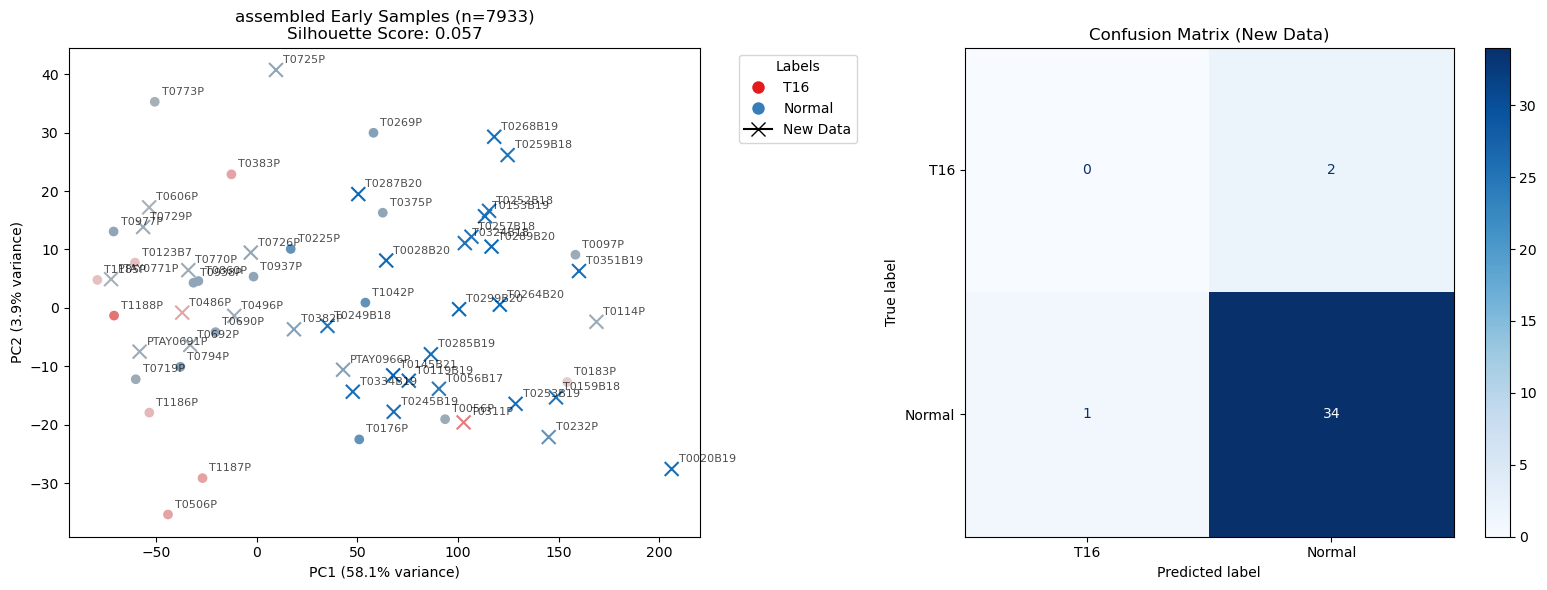

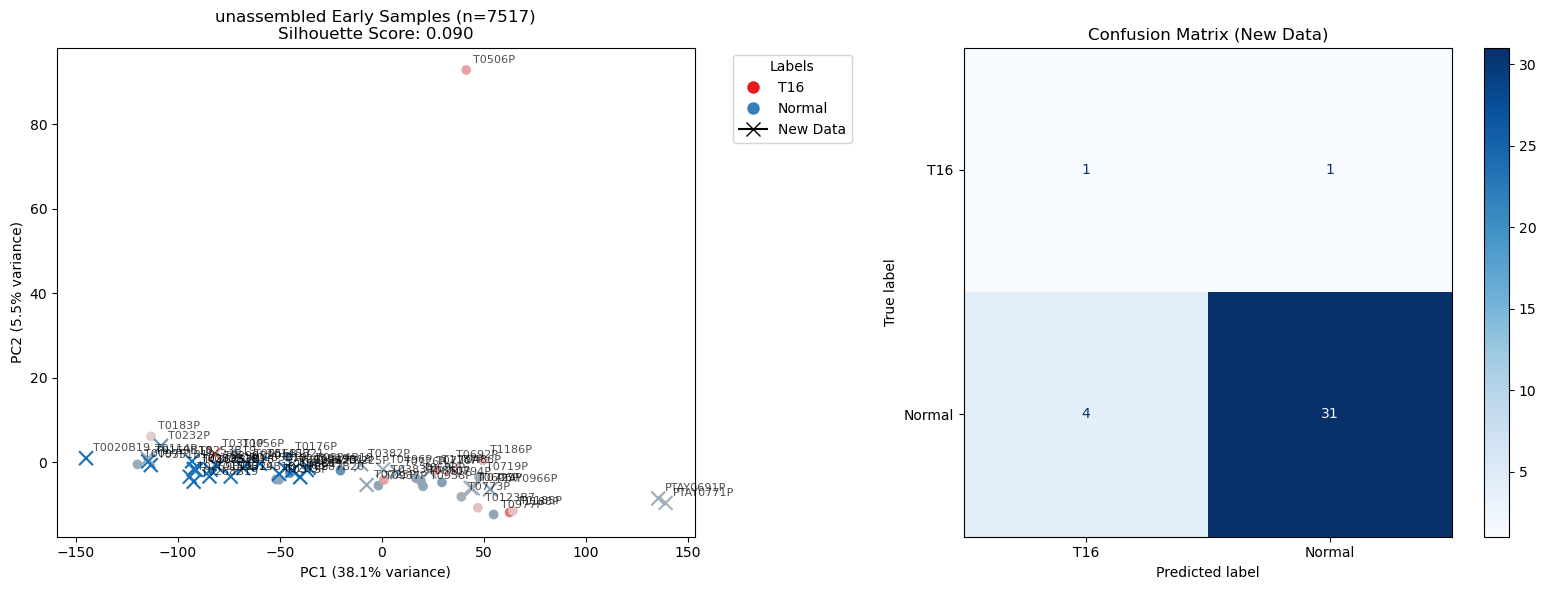

In [4]:
for assembly in ['assembled', 'unassembled']:
    df = dfs['train'][assembly].copy()
    early_df = df[df['sample'].isin(early_samples)]

    # Filter rows
    labels_to_keep = ['T16', 'Normal']
    
    feature_cols = [col for col in df.columns if ':' in col]

    # Filter cols
    # Unsupervised feature selection    
    # feature_sorted = pca_feature_selection(df)
    # feature_cols = feature_sorted[:500].tolist()
    # feature_cols = feature_sorted.tolist()

    # Supervised feature selection
    # feature_sorted = lasso_feature_selection(early_df)
    # feature_cols = feature_sorted[:1000].tolist()

    cols = ['sample', 'week', 'label'] + feature_cols
    
    df_to_plot = early_df[cols]
    df_to_plot = df_to_plot[df_to_plot['label'].isin(labels_to_keep)]
    
    add_df_1 = df[~df['sample'].isin(early_samples)][cols]
    add_df_1 = add_df_1[add_df_1['label'].isin(labels_to_keep)]
    
    add_df_2 = dfs['val'][assembly][cols]
    add_df_2 = add_df_2[add_df_2['label'].isin(labels_to_keep)]

    single_pca_plot(df_to_plot, feature_cols, labels_to_keep, f'{assembly} Early Samples', add_df_1, plot_decision_boundary=False)

Step 1: Low-variance filtering: 7933 to 7933 features retained.
Step 2: Remove highly correlated features: 7933 to 7722 features retained.


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.247e-03, tolerance: 6.500e-04
  model = cd_fast.enet_coordinate_descent(


Step 3: Lasso selected 65 non-zero features


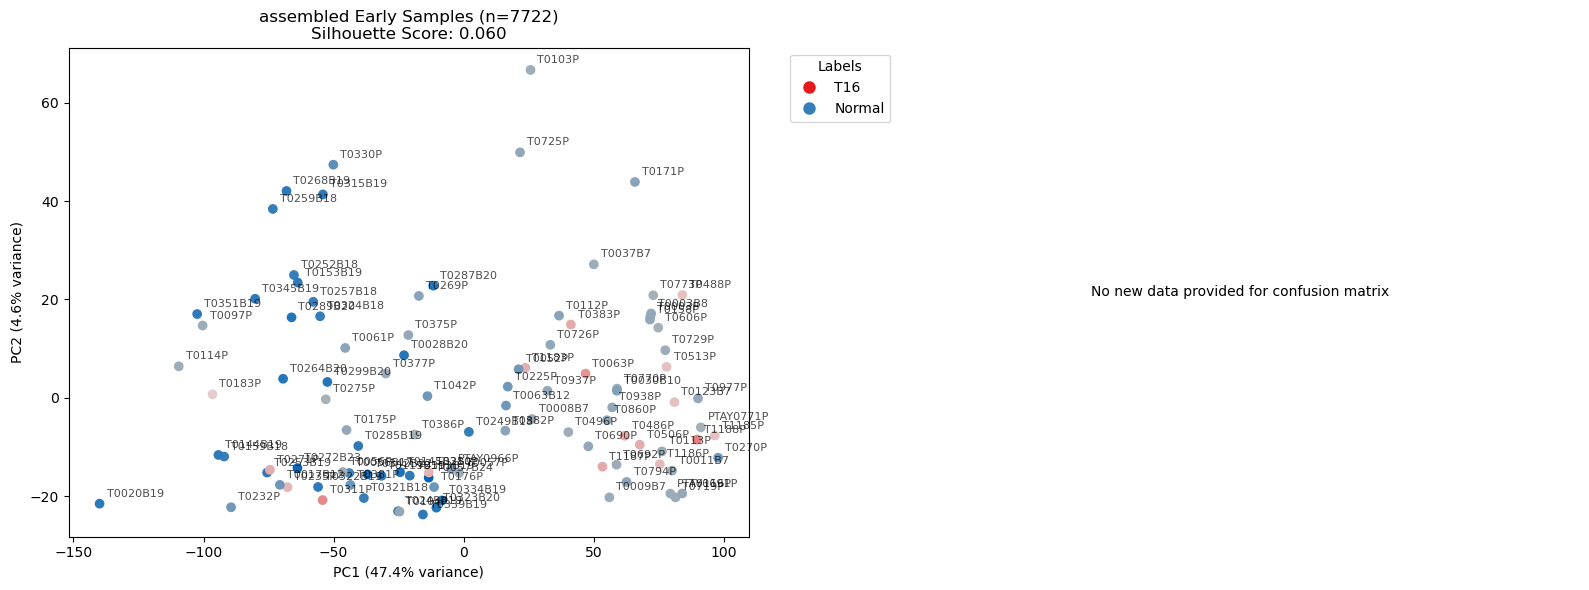

Step 1: Low-variance filtering: 7517 to 7517 features retained.
Step 2: Remove highly correlated features: 7517 to 7515 features retained.
Step 3: Lasso selected 15 non-zero features


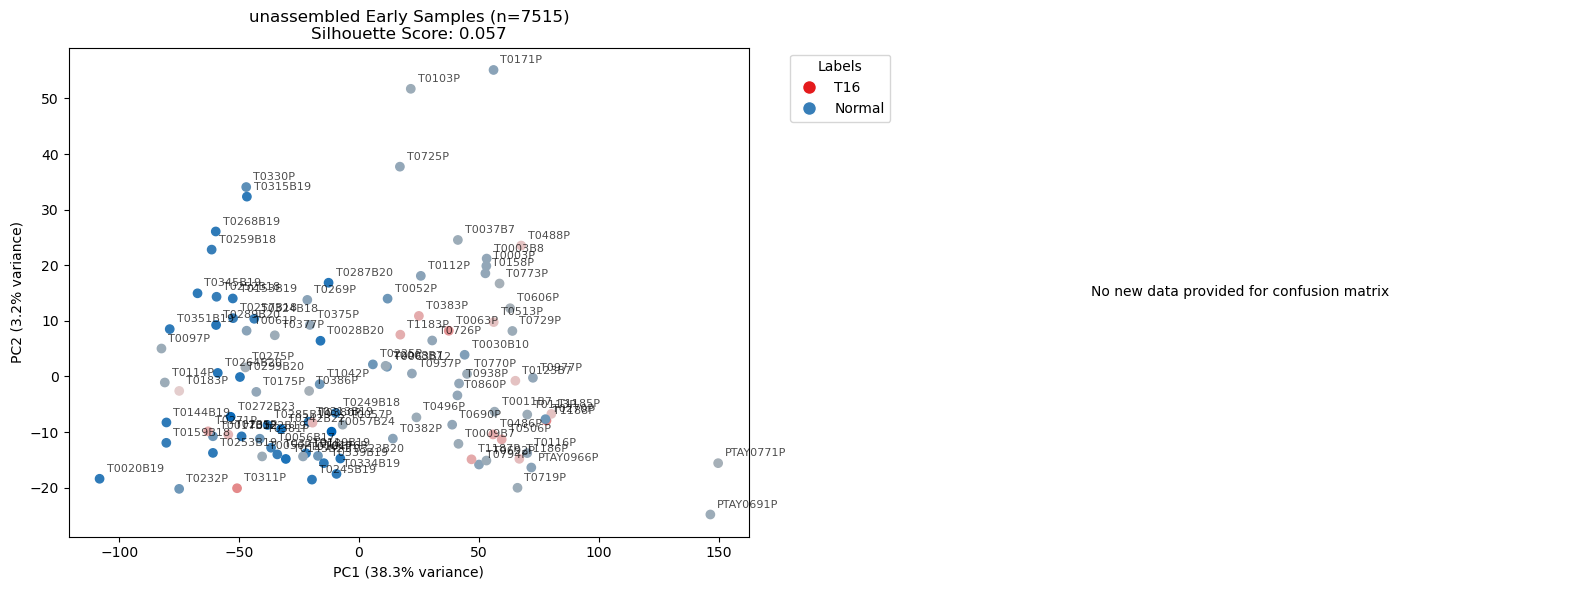

In [5]:
# Check randomly sampling as training set
for assembly in ['assembled', 'unassembled']:
    df_train = dfs['train'][assembly].copy()
    df_val = dfs['val'][assembly].copy()

    df = pd.concat([df_train, df_val], axis=0)

    # Filter rows
    state_to_drop = ['Delivered']
    df = df[~df['state'].isin(state_to_drop)]

    labels_to_keep = ['T16', 'Normal']
    df = df[df['label'].isin(labels_to_keep)]
    # df = df[df['week'] <= 13]
    
    # Balance labels by sampling
    label_counts = df['label'].value_counts()
    min_count = int(label_counts.min()*0.8)
    
    balanced_dfs = []
    for label in labels_to_keep:
        label_df = df[df['label'] == label]
        if len(label_df) > min_count:
            label_df = label_df.sample(n=min_count, random_state=42)
        balanced_dfs.append(label_df)
    
    df_train = pd.concat(balanced_dfs)
    df_val = df[~df['sample'].isin(df_train['sample'])]
    
    # Filter cols
    # Unsupervised feature selection    
    # feature_sorted = pca_feature_selection(df_train)
    # feature_cols = feature_sorted[:500].tolist()
    # feature_cols = feature_sorted.tolist()

    # Supervised feature selection
    feature_sorted = lasso_feature_selection(df_train)
    # feature_cols = feature_sorted[:500].tolist()
    feature_cols = feature_sorted.tolist()

    cols = ['sample', 'week', 'label'] + feature_cols
    
    df_train = df_train[cols]
    df_val = df_val[cols]

    single_pca_plot(df, feature_cols, labels_to_keep, f'{assembly} Early Samples', plot_decision_boundary=False)

Step 1: Low-variance filtering: 7933 to 7933 features retained.
Step 2: Remove highly correlated features: 7933 to 7663 features retained.
Step 3: Lasso selected 30 non-zero features


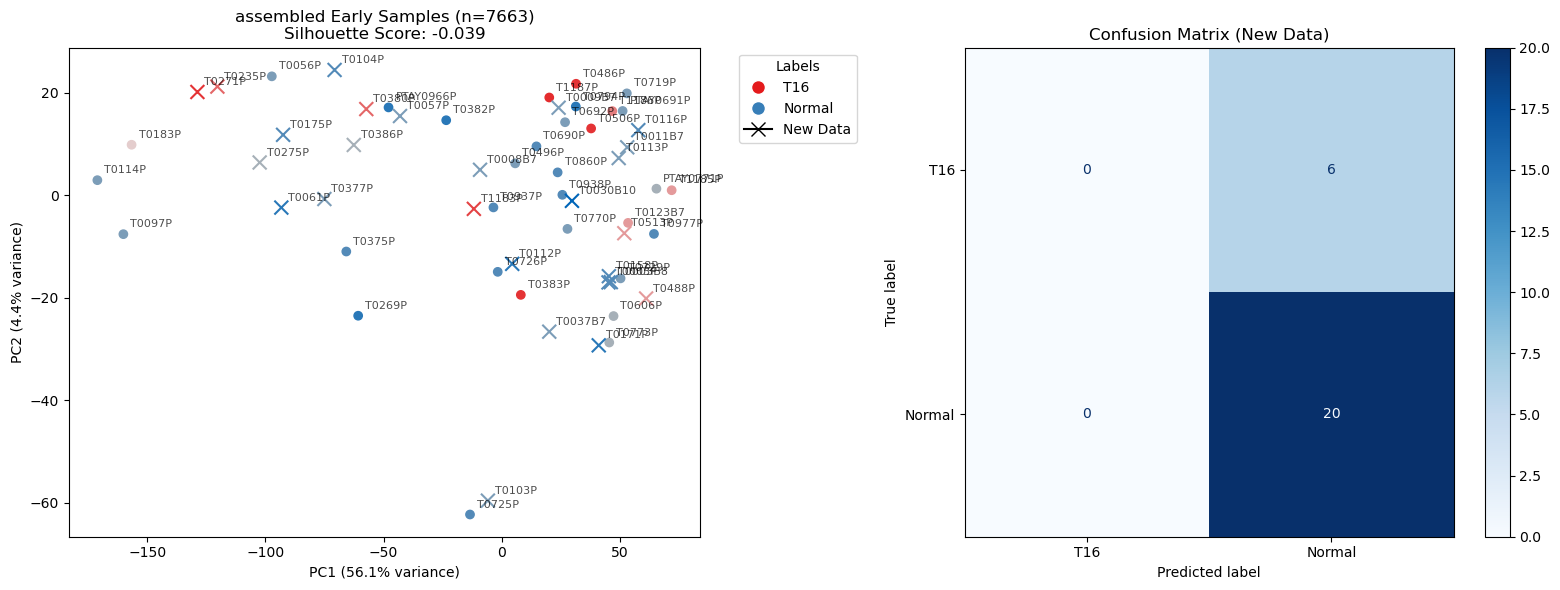

Step 1: Low-variance filtering: 7517 to 7517 features retained.
Step 2: Remove highly correlated features: 7517 to 7513 features retained.
Step 3: Lasso selected 17 non-zero features


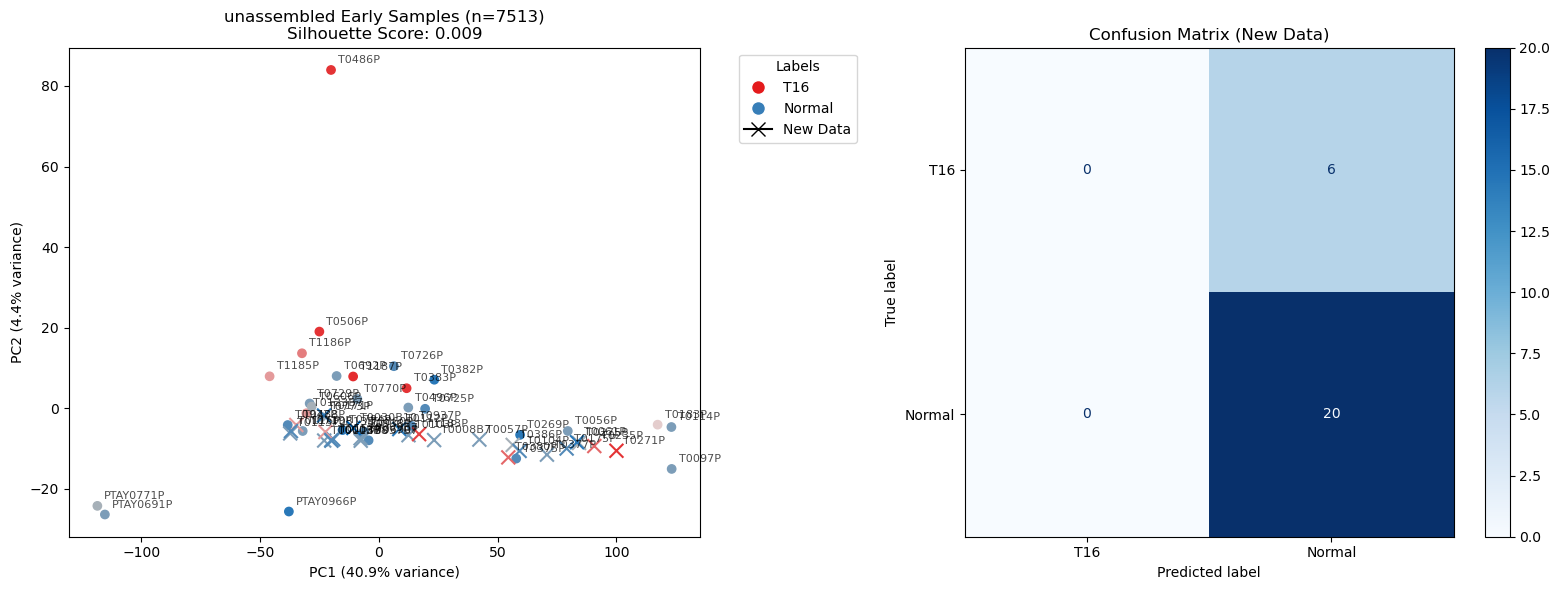

In [6]:
# Check batch effect
for assembly in ['assembled', 'unassembled']:
    df_train = dfs['train'][assembly].copy()
    df_val = dfs['val'][assembly].copy()

    df_train['batch'] = 'train'
    df_val['batch'] = 'val'

    df = pd.concat([df_train, df_val], axis=0)

    # Filter rows
    state_to_drop = ['Delivered']
    df = df[~df['state'].isin(state_to_drop)]

    labels_to_keep = ['T16', 'Normal']
    df = df[df['label'].isin(labels_to_keep)]
    df = df[df['week'] <= 10]
    
    # Balance labels by sampling
    label_counts = df['label'].value_counts()
    min_count = int(label_counts.min()*0.8)
    
    df_train = df[df['batch'] == 'train']
    df_val = df[df['batch'] == 'val']
    
    # Filter cols
    # Unsupervised feature selection    
    # feature_sorted = pca_feature_selection(df_train)
    # feature_cols = feature_sorted[:500].tolist()
    # feature_cols = feature_sorted.tolist()

    # Supervised feature selection
    feature_sorted = lasso_feature_selection(df_train)
    # feature_cols = feature_sorted[:500].tolist()
    feature_cols = feature_sorted.tolist()

    cols = ['sample', 'week', 'label'] + feature_cols
    
    df_train = df_train[cols]
    df_val = df_val[cols]

    single_pca_plot(df_train, feature_cols, labels_to_keep, f'{assembly} Early Samples', df_val, plot_decision_boundary=False)

## Early sample UMAP projection

In [ ]:
# possible mothod: 
# 1. cpgs / dmrs
# 2. pca / umap
# 3. delivered denoise